# Capacity allocation

In [7]:
!pip install -e C:\Users\hyper\PycharmProjects\robin-fuzzy

Obtaining file:///C:/Users/hyper/PycharmProjects/robin-fuzzy
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for robin (pyproject.toml): started
  Building editable for robin (pyproject.toml): finished with status 'done'
  Created wheel for robin: filename=robin-0.0.post1.dev732+g51a4223-0.editable-py3-none-any.whl size=4747 sha256=84d9405a24a99554d4bbf7cb1e20a4bcc069348c02dbafb216c1258719773714
  Stored in directory: C:\Users\hyper\AppData\Local\Temp\pip-ephem-wheel-cache-z7_mhdu5\wheels\2d\eb\84\6a919078c52f66b04d0976e3d6fa3


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU2                   3
RU3                   7
RU1                   5
RU4                   5
RU5                   5


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  25


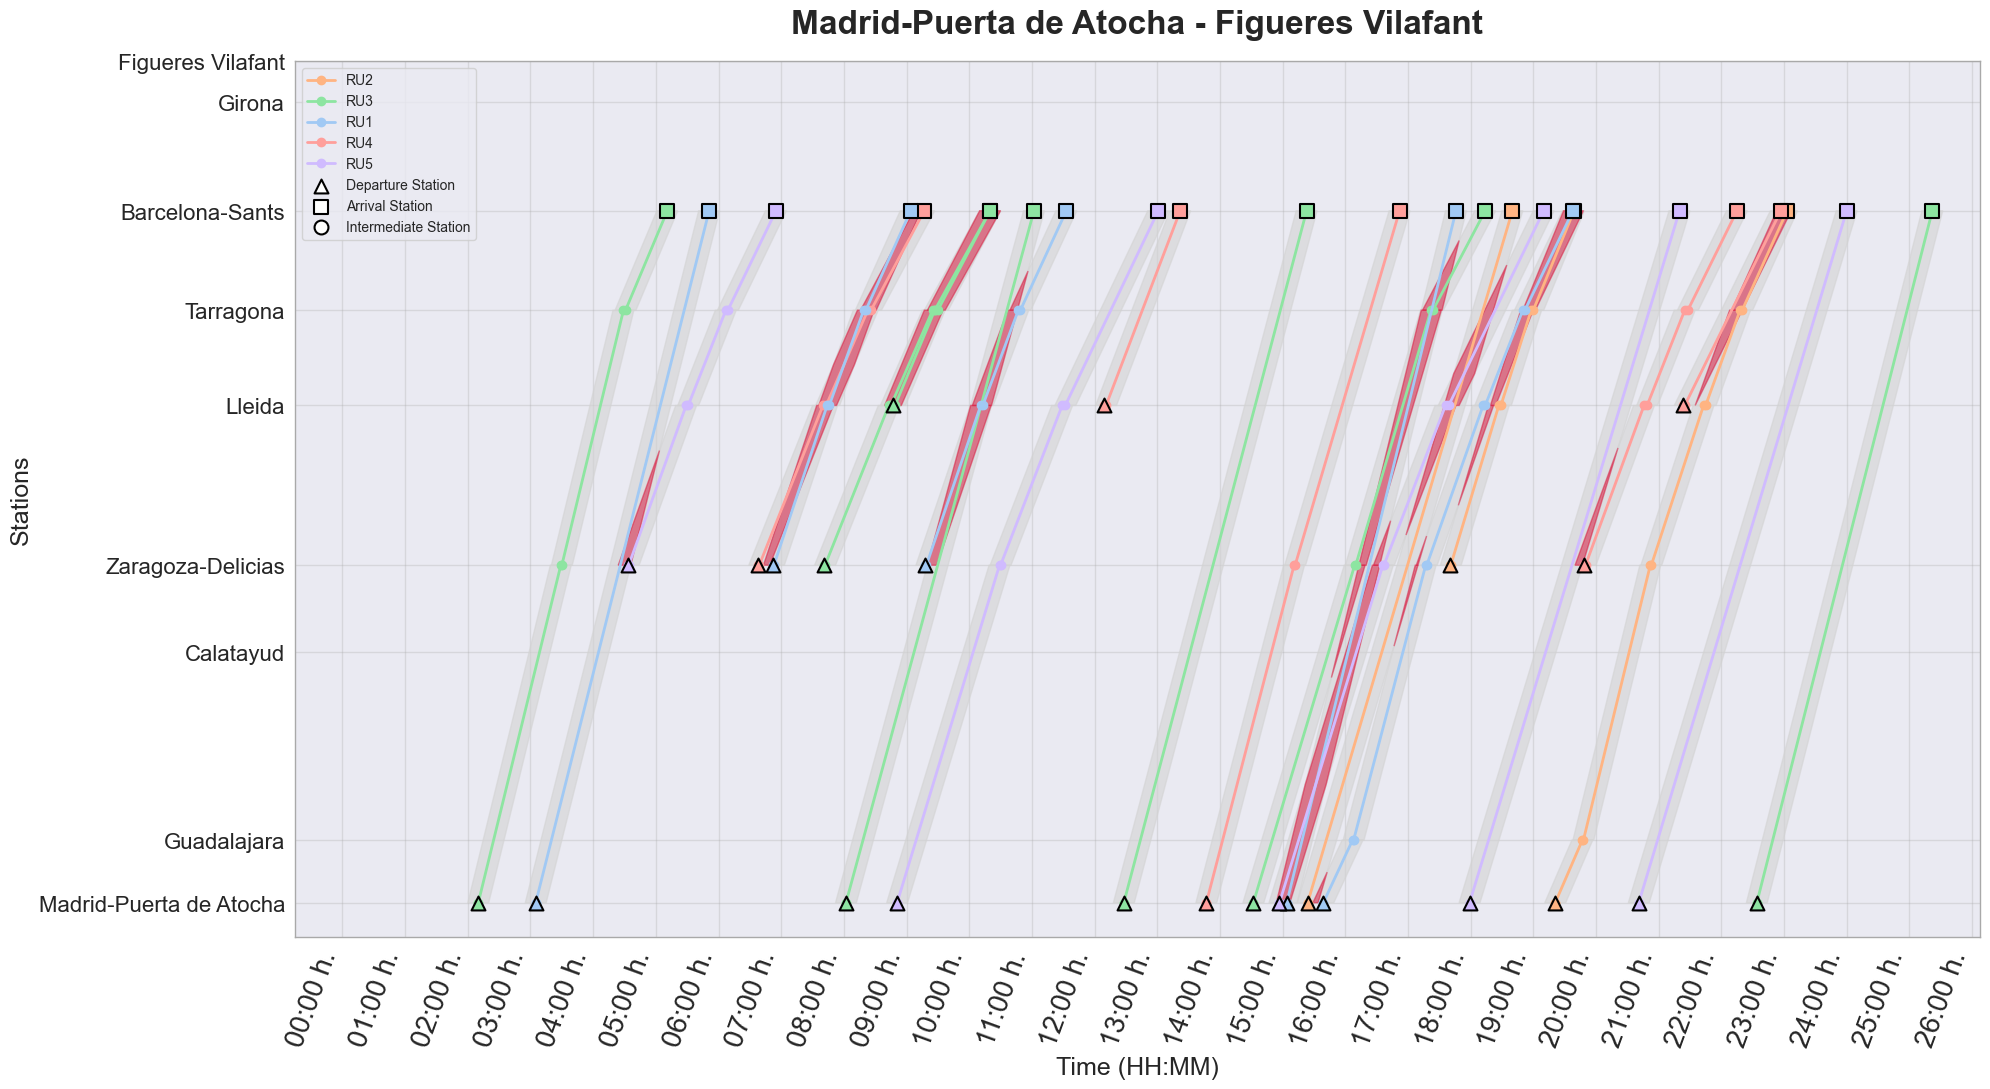

In [6]:
import datetime

date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/mealpy/'
)

## 1. Mealpy

In [7]:
from src.timetabling_problem import MPTT



In [8]:
from mealpy.evolutionary_based import DE, ES, GA
from mealpy.swarm_based import ABC, ACOR, GWO, PSO, WOA
from mealpy.physics_based import SA

mp_algos = {
    "Genetic Algorithm": GA.BaseGA,
    "Particle Swarm Optimization": PSO.OriginalPSO,
    "Simulated Annealing": SA.OriginalSA,
    "Differential Evolution": DE.OriginalDE,
    "Ant Colony Optimization Continuous (ACOR)": ACOR.OriginalACOR,
    "Covariance Matrix Adaptation Evolution Strategy": ES.CMA_ES,
    "Artificial Bee Colony": ABC.OriginalABC,
    "Grey Wolf Optimizer": GWO.OriginalGWO,
    "Whale Optimization Algorithm": WOA.OriginalWOA,
    "Hybrid Grey Wolf - Whale Optimization Algorithm": GWO.GWO_WOA
}

reports_path = Path('../reports/sensitivity_analysis/')

In [9]:
safety_headways = (5, 10, 15)
im_boundaries = (30, 45, 60)

# Get all possible combinations from two tuples
import itertools

for safety_headway, im_bound in itertools.product(safety_headways, im_boundaries):
    print(safety_headway, im_bound)

5 30
5 45
5 60
10 30
10 45
10 60
15 30
15 45
15 60


In [ ]:
from IPython.display import clear_output

from mealpy import IntegerVar

runs = 5
epochs = 100
pop_size = 50

seed_initializer = 29

safety_headways = (2.5, 5, 10)
im_boundaries = (30, 45, 60)

for safety_headway, im_bound in itertools.product(safety_headways, im_boundaries):
    mptt = MPTT(
        requested_schedule=requested_schedule,
        revenue_behavior=revenue_behaviour,
        line=line,
        safe_headway=safety_headway,
        im_mod_margin=im_bound
    )

    # 0. Problem formulation
    lb, ub = zip(*mptt.boundaries.real)

    problem = {"obj_func": mptt.objective_function,
               "bounds": IntegerVar(lb=lb,
                                  ub=ub),
               "minmax": "max",
               "save_population": True}

    # 1. Iter algorithms
    df_history = pd.DataFrame()
    df_population = pd.DataFrame()

    for algo_name, algo in mp_algos.items():

        # Re-initialize seed
        np.random.seed(seed_initializer)

        print(f"Running {algo_name}")
        for r in range(1, runs+1):
            print("\tRun: ", r)

            run_seed = np.random.randint(0, 1000)

            # Run algorithm
            if algo_name == "Simulated Annealing":
                optimizer = algo(epoch=epochs*pop_size)
                optimizer.solve(problem, seed=run_seed)
            else:
                optimizer = algo(epoch=epochs, pop_size=pop_size)
                optimizer.solve(problem, seed=run_seed)

            # Build run history dataframe
            columns = ['Algo', 'Iteration', 'Fitness', 'ExecutionTime', 'Discrete', 'Real',
                       'Diversity', 'Exploitation', 'Exploration']
            run_history = pd.DataFrame(columns=columns)

            # Save optimizer history to dataframe
            for i, data in enumerate(optimizer.history.list_global_best):
                mptt.update_schedule(data.solution)
                run_history.loc[i] = [algo_name,
                                      i,
                                      data.target.fitness,
                                      optimizer.history.list_epoch_time[i],
                                      mptt.get_heuristic_schedule_old(),
                                      data.solution,
                                      optimizer.history.list_diversity[i],
                                      optimizer.history.list_exploitation[i],
                                      optimizer.history.list_exploration[i]]

            run_history.insert(0, "Run", r)
            df_history = pd.concat([df_history, run_history], axis=0)

            # Population dataframe
            if algo_name == "Simulated Annealing":
                continue

            population_colums = [f'real_{i}' for i in range(pop_size)] + [f'discrete_{i}' for i in range(pop_size)]
            population_colums.insert(0, 'Iteration')
            run_population = pd.DataFrame(columns=population_colums)

            for i, pop_epoch in enumerate(optimizer.history.list_population):
                population_row = [i]
                real = []
                discrete = []
                for individual in pop_epoch:
                    mptt.update_schedule(individual.solution)
                    real.append(individual.solution)
                    discrete.append(mptt.get_heuristic_schedule_old())

                population_row = [i, *real, *discrete]
                run_population.loc[len(run_population)] = population_row

            run_population.insert(0, "Run", r)
            run_population.insert(1, "Algo", algo_name)
            df_population = pd.concat([df_population, run_population], axis=0)

    df_history.to_csv(reports_path / f'df_history_sh_{safety_headway}_im_{im_bound}.csv', sep=";", index=False)
    df_population.to_csv(reports_path / f'df_population_sh_{safety_headway}_im_{im_bound}.csv', sep=";", index=False)
    clear_output()

2025/05/26 10:38:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Genetic Algorithm
	Run:  1


2025/05/26 10:38:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2741.4338613240766, Global best: 2741.4338613240766, Runtime: 0.26783 seconds
2025/05/26 10:38:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2939.3114842633117, Global best: 2939.3114842633117, Runtime: 0.25638 seconds
2025/05/26 10:38:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3044.7687786365277, Global best: 3044.7687786365277, Runtime: 0.27021 seconds
2025/05/26 10:38:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3372.9661883566982, Global best: 3372.9661883566982, Runtime: 0.26418 seconds
2025/05/26 10:38:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3456.5667805004523, Global best: 3456.5667805004523, Runtime: 0.25491 seconds
2025/05/26 10:38:58 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run:  2


2025/05/26 10:39:43 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2887.2842936265965, Global best: 2887.2842936265965, Runtime: 0.24473 seconds
2025/05/26 10:39:43 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2986.8505250040585, Global best: 2986.8505250040585, Runtime: 0.25002 seconds
2025/05/26 10:39:43 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3238.007389469456, Global best: 3238.007389469456, Runtime: 0.24640 seconds
2025/05/26 10:39:43 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3621.2705906507504, Global best: 3621.2705906507504, Runtime: 0.25050 seconds
2025/05/26 10:39:44 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3623.3661103678887, Global best: 3623.3661103678887, Runtime: 0.24418 seconds
2025/05/26 10:39:44 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run:  3


2025/05/26 10:40:27 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2694.637331616334, Global best: 2694.637331616334, Runtime: 0.24540 seconds
2025/05/26 10:40:27 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2676.721146932382, Global best: 2694.637331616334, Runtime: 0.24879 seconds
2025/05/26 10:40:28 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2992.8004076989764, Global best: 2992.8004076989764, Runtime: 0.24709 seconds
2025/05/26 10:40:28 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3455.211006968798, Global best: 3455.211006968798, Runtime: 0.24704 seconds
2025/05/26 10:40:28 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3424.366586180593, Global best: 3455.211006968798, Runtime: 0.24358 seconds
2025/05/26 10:40:28 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch:

	Run:  4


2025/05/26 10:41:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2743.9782430482846, Global best: 2743.9782430482846, Runtime: 0.24087 seconds
2025/05/26 10:41:11 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2933.1241409616705, Global best: 2933.1241409616705, Runtime: 0.24745 seconds
2025/05/26 10:41:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3009.763240812242, Global best: 3009.763240812242, Runtime: 0.24245 seconds
2025/05/26 10:41:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3327.382290723206, Global best: 3327.382290723206, Runtime: 0.24601 seconds
2025/05/26 10:41:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3708.475682970793, Global best: 3708.475682970793, Runtime: 0.24476 seconds
2025/05/26 10:41:12 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run:  5


2025/05/26 10:41:55 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2830.1989028815947, Global best: 2830.1989028815947, Runtime: 0.25391 seconds
2025/05/26 10:41:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3320.490072142799, Global best: 3320.490072142799, Runtime: 0.24775 seconds
2025/05/26 10:41:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3423.0325985221016, Global best: 3423.0325985221016, Runtime: 0.24927 seconds
2025/05/26 10:41:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3614.8275088894093, Global best: 3614.8275088894093, Runtime: 0.24722 seconds
2025/05/26 10:41:56 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3814.023485693401, Global best: 3814.023485693401, Runtime: 0.24852 seconds
2025/05/26 10:41:57 AM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

Running Particle Swarm Optimization
	Run:  1


2025/05/26 10:42:40 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 3038.4584547362965, Global best: 3038.4584547362965, Runtime: 0.24945 seconds
2025/05/26 10:42:40 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 3038.4584547362965, Global best: 3038.4584547362965, Runtime: 0.24708 seconds
2025/05/26 10:42:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 3135.606121950079, Global best: 3135.606121950079, Runtime: 0.24974 seconds
2025/05/26 10:42:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3162.397794498931, Global best: 3162.397794498931, Runtime: 0.24649 seconds
2025/05/26 10:42:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3162.397794498931, Global best: 3162.397794498931, Runtime: 0.24479 seconds
2025/05/26 10:42:41 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, 

	Run:  2


2025/05/26 10:43:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2991.440935343595, Global best: 2991.440935343595, Runtime: 0.24486 seconds
2025/05/26 10:43:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2991.440935343595, Global best: 2991.440935343595, Runtime: 0.24387 seconds
2025/05/26 10:43:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 3108.1800707869133, Global best: 3108.1800707869133, Runtime: 0.24267 seconds
2025/05/26 10:43:25 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3259.1067842880625, Global best: 3259.1067842880625, Runtime: 0.24547 seconds
2025/05/26 10:43:26 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3259.1067842880625, Global best: 3259.1067842880625, Runtime: 0.24191 seconds
2025/05/26 10:43:26 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

	Run:  3


2025/05/26 10:44:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2539.4886063412273, Global best: 2539.4886063412273, Runtime: 0.24584 seconds
2025/05/26 10:44:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2841.9076783996957, Global best: 2841.9076783996957, Runtime: 0.24233 seconds
2025/05/26 10:44:09 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2841.9076783996957, Global best: 2841.9076783996957, Runtime: 0.24315 seconds
2025/05/26 10:44:10 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 2841.9076783996957, Global best: 2841.9076783996957, Runtime: 0.24678 seconds
2025/05/26 10:44:10 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3249.9080181068, Global best: 3249.9080181068, Runtime: 0.24355 seconds
2025/05/26 10:44:10 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, 

	Run:  4


2025/05/26 10:44:53 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2699.9840534275154, Global best: 2699.9840534275154, Runtime: 0.24506 seconds
2025/05/26 10:44:53 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 3106.602100323799, Global best: 3106.602100323799, Runtime: 0.24295 seconds
2025/05/26 10:44:53 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 3289.228184968704, Global best: 3289.228184968704, Runtime: 0.24642 seconds
2025/05/26 10:44:54 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3364.9763000540383, Global best: 3364.9763000540383, Runtime: 0.24052 seconds
2025/05/26 10:44:54 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3364.9763000540383, Global best: 3364.9763000540383, Runtime: 0.24729 seconds
2025/05/26 10:44:54 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6

	Run:  5


2025/05/26 10:45:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 1, Current best: 2703.31234145657, Global best: 2703.31234145657, Runtime: 0.24174 seconds
2025/05/26 10:45:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 2, Current best: 2874.4532994482333, Global best: 2874.4532994482333, Runtime: 0.24388 seconds
2025/05/26 10:45:37 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 3, Current best: 2874.4532994482333, Global best: 2874.4532994482333, Runtime: 0.24211 seconds
2025/05/26 10:45:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 4, Current best: 3209.6745187002643, Global best: 3209.6745187002643, Runtime: 0.24223 seconds
2025/05/26 10:45:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 5, Current best: 3293.630689119121, Global best: 3293.630689119121, Runtime: 0.23888 seconds
2025/05/26 10:45:38 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >>>Problem: P, Epoch: 6, 

Running Simulated Annealing
	Run:  1


2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 30, Current best: 2191.825221536572, Global best: 2191.825221536572, Runtime: 0.00489 seconds
2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 31, Current best: 2191.825221536572, Global best: 2191.825221536572, Runtime: 0.00514 seconds
2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 32, Current best: 2191.825221536572, Global best: 2191.825221536572, Runtime: 0.00560 seconds
2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 2191.825221536572, Global best: 2191.825221536572, Runtime: 0.00490 seconds
2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 2191.825221536572, Global best: 2191.825221536572, Runtime: 0.00576 seconds
2025/05/26 10:46:20 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35

	Run:  2


2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 28, Current best: 1281.81373802001, Global best: 1281.81373802001, Runtime: 0.00475 seconds
2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 29, Current best: 1281.81373802001, Global best: 1281.81373802001, Runtime: 0.00488 seconds
2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 30, Current best: 1281.81373802001, Global best: 1281.81373802001, Runtime: 0.00489 seconds
2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 31, Current best: 1281.81373802001, Global best: 1281.81373802001, Runtime: 0.00508 seconds
2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 32, Current best: 1281.81373802001, Global best: 1281.81373802001, Runtime: 0.00510 seconds
2025/05/26 10:47:09 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current 

	Run:  3


2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 31, Current best: 1825.3343649107824, Global best: 1825.3343649107824, Runtime: 0.00488 seconds
2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 32, Current best: 1825.3343649107824, Global best: 1825.3343649107824, Runtime: 0.00495 seconds
2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 1825.3343649107824, Global best: 1825.3343649107824, Runtime: 0.00516 seconds
2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 34, Current best: 1825.3343649107824, Global best: 1825.3343649107824, Runtime: 0.00476 seconds
2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 35, Current best: 1825.3343649107824, Global best: 1825.3343649107824, Runtime: 0.00509 seconds
2025/05/26 10:47:58 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  4


2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 29, Current best: 2327.1495840292673, Global best: 2327.1495840292673, Runtime: 0.00494 seconds
2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 30, Current best: 2327.1495840292673, Global best: 2327.1495840292673, Runtime: 0.00495 seconds
2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 31, Current best: 2327.1495840292673, Global best: 2327.1495840292673, Runtime: 0.00505 seconds
2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 32, Current best: 2327.1495840292673, Global best: 2327.1495840292673, Runtime: 0.00502 seconds
2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 33, Current best: 2327.1495840292673, Global best: 2327.1495840292673, Runtime: 0.00562 seconds
2025/05/26 10:48:47 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

	Run:  5


2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 27, Current best: 1753.2449956729156, Global best: 1753.2449956729156, Runtime: 0.00489 seconds
2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 28, Current best: 1753.2449956729156, Global best: 1753.2449956729156, Runtime: 0.00547 seconds
2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 29, Current best: 1753.2449956729156, Global best: 1753.2449956729156, Runtime: 0.00577 seconds
2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 30, Current best: 1753.2449956729156, Global best: 1753.2449956729156, Runtime: 0.00513 seconds
2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P, Epoch: 31, Current best: 1753.2449956729156, Global best: 1753.2449956729156, Runtime: 0.00493 seconds
2025/05/26 10:49:36 AM, INFO, mealpy.physics_based.SA.OriginalSA: >>>Problem: P,

Running Differential Evolution
	Run:  1


2025/05/26 10:50:26 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2665.6052724916503, Global best: 2665.6052724916503, Runtime: 0.24564 seconds
2025/05/26 10:50:26 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2825.444533706263, Global best: 2825.444533706263, Runtime: 0.24875 seconds
2025/05/26 10:50:26 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2825.444533706263, Global best: 2825.444533706263, Runtime: 0.24509 seconds
2025/05/26 10:50:27 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2949.2624614075794, Global best: 2949.2624614075794, Runtime: 0.25362 seconds
2025/05/26 10:50:27 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2949.2624614075794, Global best: 2949.2624614075794, Runtime: 0.24149 seconds
2025/05/26 10:50:27 AM, INFO, mealpy.evolutionary_based.DE.Origi

	Run:  2


2025/05/26 10:51:10 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2444.213887383002, Global best: 2444.213887383002, Runtime: 0.24607 seconds
2025/05/26 10:51:10 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2575.3219886075626, Global best: 2575.3219886075626, Runtime: 0.24228 seconds
2025/05/26 10:51:10 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2954.189254252159, Global best: 2954.189254252159, Runtime: 0.24447 seconds
2025/05/26 10:51:11 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 3057.3114427736446, Global best: 3057.3114427736446, Runtime: 0.23984 seconds
2025/05/26 10:51:11 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 3234.8052677696232, Global best: 3234.8052677696232, Runtime: 0.24534 seconds
2025/05/26 10:51:11 AM, INFO, mealpy.evolutionary_based.DE.Origi

	Run:  3


2025/05/26 10:51:54 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2304.3324981006185, Global best: 2304.3324981006185, Runtime: 0.24819 seconds
2025/05/26 10:51:54 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2518.2867930692555, Global best: 2518.2867930692555, Runtime: 0.24332 seconds
2025/05/26 10:51:55 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2870.1817386733846, Global best: 2870.1817386733846, Runtime: 0.24270 seconds
2025/05/26 10:51:55 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2897.130856481242, Global best: 2897.130856481242, Runtime: 0.24132 seconds
2025/05/26 10:51:55 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2897.130856481242, Global best: 2897.130856481242, Runtime: 0.24401 seconds
2025/05/26 10:51:55 AM, INFO, mealpy.evolutionary_based.DE.Origi

	Run:  4


2025/05/26 10:52:38 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2709.7308004989977, Global best: 2709.7308004989977, Runtime: 0.24406 seconds
2025/05/26 10:52:38 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2709.7308004989977, Global best: 2709.7308004989977, Runtime: 0.24491 seconds
2025/05/26 10:52:39 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2825.4187044577407, Global best: 2825.4187044577407, Runtime: 0.24319 seconds
2025/05/26 10:52:39 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2825.4187044577407, Global best: 2825.4187044577407, Runtime: 0.24962 seconds
2025/05/26 10:52:39 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2836.069221930146, Global best: 2836.069221930146, Runtime: 0.24260 seconds
2025/05/26 10:52:39 AM, INFO, mealpy.evolutionary_based.DE.Ori

	Run:  5


2025/05/26 10:53:22 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 1, Current best: 2528.1207705190545, Global best: 2528.1207705190545, Runtime: 0.24518 seconds
2025/05/26 10:53:23 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 2, Current best: 2705.44599927147, Global best: 2705.44599927147, Runtime: 0.24241 seconds
2025/05/26 10:53:23 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 3, Current best: 2705.44599927147, Global best: 2705.44599927147, Runtime: 0.24547 seconds
2025/05/26 10:53:23 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 4, Current best: 2705.44599927147, Global best: 2705.44599927147, Runtime: 0.24329 seconds
2025/05/26 10:53:23 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Problem: P, Epoch: 5, Current best: 2705.44599927147, Global best: 2705.44599927147, Runtime: 0.24787 seconds
2025/05/26 10:53:24 AM, INFO, mealpy.evolutionary_based.DE.OriginalDE: >>>Pr

Running Ant Colony Optimization Continuous (ACOR)
	Run:  1


2025/05/26 10:54:06 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2273.87423755497, Global best: 2273.87423755497, Runtime: 0.15128 seconds
2025/05/26 10:54:06 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2589.487709634885, Global best: 2589.487709634885, Runtime: 0.14975 seconds
2025/05/26 10:54:07 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2589.487709634885, Global best: 2589.487709634885, Runtime: 0.14642 seconds
2025/05/26 10:54:07 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2589.487709634885, Global best: 2589.487709634885, Runtime: 0.15140 seconds
2025/05/26 10:54:07 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2618.298554824964, Global best: 2618.298554824964, Runtime: 0.14770 seconds
2025/05/26 10:54:07 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoc

	Run:  2


2025/05/26 10:54:40 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2785.0915999145323, Global best: 2785.0915999145323, Runtime: 0.14918 seconds
2025/05/26 10:54:41 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2785.0915999145323, Global best: 2785.0915999145323, Runtime: 0.15240 seconds
2025/05/26 10:54:41 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2785.0915999145323, Global best: 2785.0915999145323, Runtime: 0.14933 seconds
2025/05/26 10:54:41 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2785.0915999145323, Global best: 2785.0915999145323, Runtime: 0.15298 seconds
2025/05/26 10:54:41 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2785.0915999145323, Global best: 2785.0915999145323, Runtime: 0.14875 seconds
2025/05/26 10:54:41 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  3


2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2762.0790052957163, Global best: 2762.0790052957163, Runtime: 0.14994 seconds
2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2762.0790052957163, Global best: 2762.0790052957163, Runtime: 0.14677 seconds
2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2762.0790052957163, Global best: 2762.0790052957163, Runtime: 0.15067 seconds
2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2762.0790052957163, Global best: 2762.0790052957163, Runtime: 0.14665 seconds
2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2762.0790052957163, Global best: 2762.0790052957163, Runtime: 0.14986 seconds
2025/05/26 10:55:15 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  4


2025/05/26 10:55:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2699.9840534275154, Global best: 2699.9840534275154, Runtime: 0.14810 seconds
2025/05/26 10:55:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2699.9840534275154, Global best: 2699.9840534275154, Runtime: 0.15045 seconds
2025/05/26 10:55:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2701.7053027018983, Global best: 2701.7053027018983, Runtime: 0.14724 seconds
2025/05/26 10:55:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2701.7053027018983, Global best: 2701.7053027018983, Runtime: 0.14675 seconds
2025/05/26 10:55:49 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 3134.1608909275915, Global best: 3134.1608909275915, Runtime: 0.14461 seconds
2025/05/26 10:55:50 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

	Run:  5


2025/05/26 10:56:23 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 1, Current best: 2528.1207705190545, Global best: 2528.1207705190545, Runtime: 0.14857 seconds
2025/05/26 10:56:23 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 2, Current best: 2528.1207705190545, Global best: 2528.1207705190545, Runtime: 0.14995 seconds
2025/05/26 10:56:23 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 3, Current best: 2528.1207705190545, Global best: 2528.1207705190545, Runtime: 0.15131 seconds
2025/05/26 10:56:24 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 4, Current best: 2598.6942203168437, Global best: 2598.6942203168437, Runtime: 0.14726 seconds
2025/05/26 10:56:24 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Problem: P, Epoch: 5, Current best: 2659.2003312618804, Global best: 2659.2003312618804, Runtime: 0.14674 seconds
2025/05/26 10:56:24 AM, INFO, mealpy.swarm_based.ACOR.OriginalACOR: >>>Prob

Running Covariance Matrix Adaptation Evolution Strategy
	Run:  1


2025/05/26 10:56:58 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3355.775440454468, Global best: 3355.775440454468, Runtime: 0.40809 seconds
2025/05/26 10:56:58 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3532.281874839962, Global best: 3532.281874839962, Runtime: 0.45252 seconds
2025/05/26 10:56:59 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3101.349343514482, Global best: 3532.281874839962, Runtime: 0.43114 seconds
2025/05/26 10:56:59 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 2989.7475606233597, Global best: 3532.281874839962, Runtime: 0.44535 seconds
2025/05/26 10:56:59 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3218.776719515572, Global best: 3532.281874839962, Runtime: 0.43894 seconds
2025/05/26 10:57:00 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 

	Run:  2


2025/05/26 10:58:01 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3133.754715366841, Global best: 3133.754715366841, Runtime: 0.39300 seconds
2025/05/26 10:58:02 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3063.4305624073377, Global best: 3133.754715366841, Runtime: 0.42553 seconds
2025/05/26 10:58:02 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3413.8831979426227, Global best: 3413.8831979426227, Runtime: 0.42442 seconds
2025/05/26 10:58:02 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3225.361997906253, Global best: 3413.8831979426227, Runtime: 0.42455 seconds
2025/05/26 10:58:03 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 2738.2141913477126, Global best: 3413.8831979426227, Runtime: 0.43876 seconds
2025/05/26 10:58:03 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Ep

	Run:  3


2025/05/26 10:59:05 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3380.977159492969, Global best: 3380.977159492969, Runtime: 0.41218 seconds
2025/05/26 10:59:05 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3451.4161895351194, Global best: 3451.4161895351194, Runtime: 0.43691 seconds
2025/05/26 10:59:05 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3281.2998134574864, Global best: 3451.4161895351194, Runtime: 0.41994 seconds
2025/05/26 10:59:06 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3188.82082046185, Global best: 3451.4161895351194, Runtime: 0.42429 seconds
2025/05/26 10:59:06 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3031.97529441518, Global best: 3451.4161895351194, Runtime: 0.42127 seconds
2025/05/26 10:59:07 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoc

	Run:  4


2025/05/26 11:00:08 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 1, Current best: 3380.15926706535, Global best: 3380.15926706535, Runtime: 0.41198 seconds
2025/05/26 11:00:09 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 2, Current best: 3372.233834184689, Global best: 3380.15926706535, Runtime: 0.44528 seconds
2025/05/26 11:00:09 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 3, Current best: 3542.8933566140354, Global best: 3542.8933566140354, Runtime: 0.43791 seconds
2025/05/26 11:00:10 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 4, Current best: 3394.4680031603375, Global best: 3542.8933566140354, Runtime: 0.45640 seconds
2025/05/26 11:00:10 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch: 5, Current best: 3109.6925753416763, Global best: 3542.8933566140354, Runtime: 0.44750 seconds
2025/05/26 11:00:10 AM, INFO, mealpy.evolutionary_based.ES.CMA_ES: >>>Problem: P, Epoch

## 2. Results analysis

In [10]:
reports_path = Path('../reports/mealpy_timetabling/')

In [11]:
df_history.to_csv(reports_path / 'df_history_50.csv', sep=";", index=False)

In [12]:
df_population.to_csv(reports_path / 'df_population_50.csv', sep=";", index=False)

In [14]:
df_history = pd.read_csv(reports_path / 'df_history_50.csv', sep=";")
df_population = pd.read_csv(reports_path / 'df_population_50.csv', sep=";")

In [15]:
df_history

Run                                             Algo  Iteration  \
0        1                                Genetic Algorithm          0   
1        1                                Genetic Algorithm          1   
2        1                                Genetic Algorithm          2   
3        1                                Genetic Algorithm          3   
4        1                                Genetic Algorithm          4   
...    ...                                              ...        ...   
29495    5  Hybrid Grey Wolf - Whale Optimization Algorithm         95   
29496    5  Hybrid Grey Wolf - Whale Optimization Algorithm         96   
29497    5  Hybrid Grey Wolf - Whale Optimization Algorithm         97   
29498    5  Hybrid Grey Wolf - Whale Optimization Algorithm         98   
29499    5  Hybrid Grey Wolf - Whale Optimization Algorithm         99   

           Fitness  ExecutionTime  \
0      2818.988083       0.814831   
1      2984.560304       0.819751   
2      3339.284099       0.811719   
3      4039.305060       0.805602   
4      4039.305060       0.811742   
...            ...            ...   
29495  3668.078835       0.780279   
29496  3668.078835       0.782762   
29497  3668.078835       0.780408   
29498  3668.078835       0.781112   
29499  3668.078835       0.784435   

                                                Discrete  \
0      [False False False False  True False  True Fal...   
1      [False False False False  True False  True Fal...   
2      [False False False False  True False  True Fal...   
3      [False False False False  True False  True Fal...   
4      [False False False False  True False  True Fal...   
...                                                  ...   
29495  [False False False False  True False  True  Tr...   
29496  [False False False False  True False  True  Tr...   
29497  [False False False False  True False  True  Tr...   
29498  [False False False False  True False  True  Tr...   
29499  [False False False False  True False  True  Tr...   

                                                    Real  Diversity  \
0      [1012. 1116. 1145.  916.  975. 1044.  844.  88...  12.316066   
1      [1012. 1115. 1142.  904.  975. 1044.  875.  88...  10.818689   
2      [1057. 1115. 1146.  916.  975. 1048.  964.  85...   9.320164   
3      [1057. 1116. 1146.  916.  972. 1048.  964.  88...   9.031311   
4      [1057. 1116. 1146.  916.  972. 1048.  964.  88...   8.353443   
...                                                  ...        ...   
29495  [1121.4999     1117.4999     1148.4999      93...  19.306392   
29496  [1121.4999     1117.4999     1148.4999      93...  19.148566   
29497  [1121.4999     1117.4999     1148.4999      93...  19.147746   
29498  [1121.4999     1117.4999     1148.4999      93...  19.147048   
29499  [1121.4999     1117.4999     1148.4999      93...  19.147048   

       Exploitation  Exploration  
0          0.000000   100.000000  
1         12.157917    87.842083  
2         24.325152    75.674848  
3         26.670482    73.329518  
4         32.174422    67.825578  
...             ...          ...  
29495     11.301723    88.698277  
29496     12.026817    87.973183  
29497     12.030580    87.969420  
29498     12.033789    87.966211  
29499     12.033789    87.966211  

[29500 rows x 10 columns]

In [16]:
df_population.head()

Run               Algo  Iteration  \
0    1  Genetic Algorithm          0   
1    1  Genetic Algorithm          1   
2    1  Genetic Algorithm          2   
3    1  Genetic Algorithm          3   
4    1  Genetic Algorithm          4   

                                              real_0  \
0  [1092. 1117. 1141.  906.  972. 1047.  964.  85...   
1  [1046. 1115. 1140.  897.  970. 1052.  875.  79...   
2  [1057. 1114. 1142.  904.  979. 1046.  900.  78...   
3  [1018. 1116. 1143.  916.  975. 1052.  844.  77...   
4  [1018. 1116. 1146.  916.  975. 1048.  900.  83...   

                                              real_1  \
0  [1019. 1116. 1145.  906.  972. 1050.  858.  81...   
1  [1061. 1114. 1142.  904.  979. 1046.  915.  78...   
2  [1061. 1116. 1146.  916.  975. 1048.  915.  78...   
3  [1046. 1115. 1140.  897.  976. 1052.  875.  87...   
4  [1057. 1116. 1146.  916.  975. 1052.  900.  78...   

                                              real_2  \
0  [1046. 1116. 1145.  862.  970. 1045.  852.  79...   
1  [1019. 1115. 1145.  910.  975. 1052.  858.  85...   
2  [1018. 1116. 1146.  916.  978. 1052.  844.  87...   
3  [1057. 1115. 1146.  831.  975. 1048.  964.  85...   
4  [1072. 1110. 1140.  916.  975. 1048.  964.  77...   

                                              real_3  \
0  [1018. 1115. 1142.  904.  976. 1052.  875.  87...   
1  [1046. 1117. 1142.  904.  972. 1048.  875.  79...   
2  [1057. 1116. 1145.  916.  976. 1048.  844.  88...   
3  [1057. 1116. 1146.  916.  975. 1048.  900.  78...   
4  [1072. 1110. 1140.  916.  975. 1048.  875.  84...   

                                              real_4  \
0  [1057. 1115. 1146.  904.  978. 1048.  964.  85...   
1  [1116. 1113. 1145.  812.  972. 1048.  858.  80...   
2  [1018. 1117. 1145.  910.  976. 1048.  858.  87...   
3  [1018. 1116. 1146.  916.  975. 1052.  900.  78...   
4  [1012. 1115. 1143.  916.  975. 1048.  875.  88...   

                                              real_5  \
0  [1116. 1113. 1141.  907.  972. 1048.  900.  78...   
1  [1072. 1116. 1141.  904.  972. 1051.  915.  77...   
2  [1057. 1115. 1142.  904.  972. 1048.  900.  85...   
3  [1057. 1116. 1143.  831.  975. 1048.  844.  77...   
4  [1012. 1115. 1145.  897.  975. 1052.  897.  88...   

                                              real_6  ...  \
0  [1092. 1116. 1141.  906.  972. 1050.  964.  81...  ...   
1  [1072. 1117. 1147.  812.  972. 1051.  915.  85...  ...   
2  [1081. 1113. 1146.  904.  975. 1048.  900.  78...  ...   
3  [1072. 1115. 1146.  875.  979. 1048.  875.  77...  ...   
4  [1012. 1115. 1145.  916.  976. 1052.  875.  88...  ...   

                                         discrete_40  \
0  [False False False False  True False False  Tr...   
1  [False False False False  True False False Fal...   
2  [False False False False  True  True False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_41  \
0  [False  True False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_42  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False False Fal...   

                                         discrete_43  \
0  [False False False False  True False False Fal...   
1  [False  True False False  True False  True Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False False Fal...   

                         

In [17]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2818.988083       0.814831   
1    1  Genetic Algorithm          1  2984.560304       0.819751   
2    1  Genetic Algorithm          2  3339.284099       0.811719   
3    1  Genetic Algorithm          3  4039.305060       0.805602   
4    1  Genetic Algorithm          4  4039.305060       0.811742   

                                            Discrete  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False  True Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False  True Fal...   

                                                Real  Diversity  Exploitation  \
0  [1012, 1116, 1145, 916, 975, 1044, 844, 882, 9...  12.316066      0.000000   
1  [1012, 1115, 1142, 904, 975, 1044, 875, 882, 9...  10.818689     12.157917   
2  [1057, 1115, 1146, 916, 975, 1048, 964, 854, 9...   9.320164     24.325152   
3  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   9.031311     26.670482   
4  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   8.353443     32.174422   

   Exploration  
0   100.000000  
1    87.842083  
2    75.674848  
3    73.329518  
4    67.825578

In [18]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2818.988083       0.814831   
1    1  Genetic Algorithm          1  2984.560304       0.819751   
2    1  Genetic Algorithm          2  3339.284099       0.811719   
3    1  Genetic Algorithm          3  4039.305060       0.805602   
4    1  Genetic Algorithm          4  4039.305060       0.811742   

                                            Discrete  \
0  [False, False, False, False, True, False, True...   
1  [False, False, False, False, True, False, True...   
2  [False, False, False, False, True, False, True...   
3  [False, False, False, False, True, False, True...   
4  [False, False, False, False, True, False, True...   

                                                Real  Diversity  Exploitation  \
0  [1012, 1116, 1145, 916, 975, 1044, 844, 882, 9...  12.316066      0.000000   
1  [1012, 1115, 1142, 904, 975, 1044, 875, 882, 9...  10.818689     12.157917   
2  [1057, 1115, 1146, 916, 975, 1048, 964, 854, 9...   9.320164     24.325152   
3  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   9.031311     26.670482   
4  [1057, 1116, 1146, 916, 972, 1048, 964, 882, 9...   8.353443     32.174422   

   Exploration  
0   100.000000  
1    87.842083  
2    75.674848  
3    73.329518  
4    67.825578

In [19]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

Run               Algo  Iteration  \
0    1  Genetic Algorithm          0   
1    1  Genetic Algorithm          1   
2    1  Genetic Algorithm          2   
3    1  Genetic Algorithm          3   
4    1  Genetic Algorithm          4   

                                              real_0  \
0  [1092.0, 1117.0, 1141.0, 906.0, 972.0, 1047.0,...   
1  [1046.0, 1115.0, 1140.0, 897.0, 970.0, 1052.0,...   
2  [1057.0, 1114.0, 1142.0, 904.0, 979.0, 1046.0,...   
3  [1018.0, 1116.0, 1143.0, 916.0, 975.0, 1052.0,...   
4  [1018.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   

                                              real_1  \
0  [1019.0, 1116.0, 1145.0, 906.0, 972.0, 1050.0,...   
1  [1061.0, 1114.0, 1142.0, 904.0, 979.0, 1046.0,...   
2  [1061.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   
3  [1046.0, 1115.0, 1140.0, 897.0, 976.0, 1052.0,...   
4  [1057.0, 1116.0, 1146.0, 916.0, 975.0, 1052.0,...   

                                              real_2  \
0  [1046.0, 1116.0, 1145.0, 862.0, 970.0, 1045.0,...   
1  [1019.0, 1115.0, 1145.0, 910.0, 975.0, 1052.0,...   
2  [1018.0, 1116.0, 1146.0, 916.0, 978.0, 1052.0,...   
3  [1057.0, 1115.0, 1146.0, 831.0, 975.0, 1048.0,...   
4  [1072.0, 1110.0, 1140.0, 916.0, 975.0, 1048.0,...   

                                              real_3  \
0  [1018.0, 1115.0, 1142.0, 904.0, 976.0, 1052.0,...   
1  [1046.0, 1117.0, 1142.0, 904.0, 972.0, 1048.0,...   
2  [1057.0, 1116.0, 1145.0, 916.0, 976.0, 1048.0,...   
3  [1057.0, 1116.0, 1146.0, 916.0, 975.0, 1048.0,...   
4  [1072.0, 1110.0, 1140.0, 916.0, 975.0, 1048.0,...   

                                              real_4  \
0  [1057.0, 1115.0, 1146.0, 904.0, 978.0, 1048.0,...   
1  [1116.0, 1113.0, 1145.0, 812.0, 972.0, 1048.0,...   
2  [1018.0, 1117.0, 1145.0, 910.0, 976.0, 1048.0,...   
3  [1018.0, 1116.0, 1146.0, 916.0, 975.0, 1052.0,...   
4  [1012.0, 1115.0, 1143.0, 916.0, 975.0, 1048.0,...   

                                              real_5  \
0  [1116.0, 1113.0, 1141.0, 907.0, 972.0, 1048.0,...   
1  [1072.0, 1116.0, 1141.0, 904.0, 972.0, 1051.0,...   
2  [1057.0, 1115.0, 1142.0, 904.0, 972.0, 1048.0,...   
3  [1057.0, 1116.0, 1143.0, 831.0, 975.0, 1048.0,...   
4  [1012.0, 1115.0, 1145.0, 897.0, 975.0, 1052.0,...   

                                              real_6  ...  \
0  [1092.0, 1116.0, 1141.0, 906.0, 972.0, 1050.0,...  ...   
1  [1072.0, 1117.0, 1147.0, 812.0, 972.0, 1051.0,...  ...   
2  [1081.0, 1113.0, 1146.0, 904.0, 975.0, 1048.0,...  ...   
3  [1072.0, 1115.0, 1146.0, 875.0, 979.0, 1048.0,...  ...   
4  [1012.0, 1115.0, 1145.0, 916.0, 976.0, 1052.0,...  ...   

                                         discrete_40  \
0  [False False False False  True False False  Tr...   
1  [False False False False  True False False Fal...   
2  [False False False False  True  True False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_41  \
0  [False  True False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False  True Fal...   

                                         discrete_42  \
0  [False False False False  True False  True Fal...   
1  [False False False False  True False False Fal...   
2  [False False False False  True False  True Fal...   
3  [False False False False  True False False Fal...   
4  [False False False False  True False False Fal...   

                                         discrete_43  \
0  [False False False False  True False False Fal...   
1  [False  True False False  True False  True Fal...   
2  [False False False False  True False False Fal...   
3  [False False False False  True False  True Fal...   
4  [False False False False  True False False Fal...   

                         

In [39]:
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behaviour=revenue_behaviour,
            line=line,
            safe_headway=10)

top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['Algo'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["Algo"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

# Iterate through the dataframe and apply the function with progress feedback
real_columns = df_pop.columns[df_pop.columns.str.contains('real_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['Algo']

    # Print message if there's a change in 'Run' or 'Algo'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, Algo = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, real_columns] = row[real_columns].map(fitness_from_real)

print("Processing completed.")
df_pop

Filtered algos: {'Genetic Algorithm', 'Particle Swarm Optimization', 'Ant Colony Optimization Continuous (ACOR)'}
Processing new combination: Run = 1, Algo = Genetic Algorithm
Processing new combination: Run = 2, Algo = Genetic Algorithm
Processing new combination: Run = 3, Algo = Genetic Algorithm
Processing new combination: Run = 4, Algo = Genetic Algorithm
Processing new combination: Run = 5, Algo = Genetic Algorithm
Processing new combination: Run = 1, Algo = Particle Swarm Optimization
Processing new combination: Run = 2, Algo = Particle Swarm Optimization
Processing new combination: Run = 3, Algo = Particle Swarm Optimization
Processing new combination: Run = 4, Algo = Particle Swarm Optimization
Processing new combination: Run = 5, Algo = Particle Swarm Optimization
Processing new combination: Run = 1, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 2, Algo = Ant Colony Optimization Continuous (ACOR)
Processing new combination: Run = 3, Algo = 

Run                                       Algo  Iteration       real_0  \
0       1                          Genetic Algorithm          0  2031.274616   
1       1                          Genetic Algorithm          1  1513.822155   
2       1                          Genetic Algorithm          2  2574.487027   
3       1                          Genetic Algorithm          3  2375.365337   
4       1                          Genetic Algorithm          4  2453.410759   
...   ...                                        ...        ...          ...   
1995    5  Ant Colony Optimization Continuous (ACOR)         95  3692.794172   
1996    5  Ant Colony Optimization Continuous (ACOR)         96  3692.794172   
1997    5  Ant Colony Optimization Continuous (ACOR)         97  3692.794172   
1998    5  Ant Colony Optimization Continuous (ACOR)         98  3692.794172   
1999    5  Ant Colony Optimization Continuous (ACOR)         99  3692.794172   

           real_1       real_2       real_3       real_4       real_5  \
0     1238.495834  1454.067189  1708.999292  1567.878493  1363.951559   
1     1589.064022  1676.857797  2004.254684  2051.601594  2032.051679   
2     2189.309044  2382.830394  1668.250295  1953.326642  2148.220783   
3     2524.283179   2535.26969  2294.927868  2089.175561  2678.906595   
4     2373.076516  2504.878756  2682.496976  2624.696231  2403.293926   
...           ...          ...          ...          ...          ...   
1995  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1996  3685.706292   3559.06688  3550.647771   3544.21025  3529.065126   
1997  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1998  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   
1999  3685.706292  3598.262559   3559.06688  3550.647771   3544.21025   

           real_6  ...      real_40      real_41      real_42      real_43  \
0     1205.755739  ...  1948.765285  1652.308142  1676.024006  1266.957476   
1     1989.344209  ...  1694.746416  1868.030395  1525.331948  2102.729305   
2     1730.720701  ...  1525.331948  2332.021901  1881.442388  1568.197601   
3     2126.069778  ...  2428.805172  2113.841627  2063.691475  2926.528932   
4     2579.238137  ...  2114.839845  2372.867859  2937.469505  2705.032673   
...           ...  ...          ...          ...          ...          ...   
1995  3524.649683  ...  3336.891378  3325.545799  3318.106678  3317.776329   
1996  3524.649683  ...  3347.176764  3343.484176  3336.891378  3325.545799   
1997  3529.065126  ...  3352.309698  3349.914224  3347.176764  3343.484176   
1998  3529.065126  ...   3353.63659  3353.209045  3352.309698  3349.914224   
1999  3529.065126  ...  3359.280919    3355.6436   3353.63659  3353.209045   

          real_44      real_45      real_46      real_47      real_48  \
0     1788.940114  1596.962909  1436.649289  1594.477773   1210.28417   
1     2007.498897  1585.386075  1489.380892  2294.927868  1337.848235   
2     2266.160896  2172.970352  2508.743616  2459.141069  1795.164054   
3     2298.234973  1967.041629   2051.00493  2046.372591  2062.046343   
4     2269.372136  2428.818704  2146.880408  2435.213856  2168.901945   
...           ...          ...          ...          ...          ...   
1995  3317.534158  3313.564225  3305.446377  3299.247901  3295.066858   
1996  3318.106678  3317.776329  3317.534158  3313.564225  3305.446377   
1997  3337.386799  3336.891378  3325.545799  3318.106678  3317.776329   
1998  3347.176764  3343.484176  3337.386799  3336.891378  3325.545799   
1999  3352.309698  3349.914224  3347.176764  3343.484176  3337.386799   

          real_49  
0     1479.103047  
1     1205.755739  
2     2264.969528  
3      2006.82101  
4     2778.377188  
...           ...  
1995  3294.153695  
1996  3299.247901  
1997  3317.534158  
1998  3318.106678  
1999  3336.891378  

[1500 rows x 53 columns]

In [41]:
# Save df_pop
df_pop.to_csv(reports_path / 'df_pop_5_seed_fit_top3.csv', sep=";", index=False)

In [42]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['Algo']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Algorithm': algo, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

Run  Iteration      Fitness                                  Algorithm  \
0        1          0  2031.274616                          Genetic Algorithm   
1        1          0  1238.495834                          Genetic Algorithm   
2        1          0  1454.067189                          Genetic Algorithm   
3        1          0  1708.999292                          Genetic Algorithm   
4        1          0  1567.878493                          Genetic Algorithm   
...    ...        ...          ...                                        ...   
74995    5         99  3349.914224  Ant Colony Optimization Continuous (ACOR)   
74996    5         99  3347.176764  Ant Colony Optimization Continuous (ACOR)   
74997    5         99  3343.484176  Ant Colony Optimization Continuous (ACOR)   
74998    5         99  3337.386799  Ant Colony Optimization Continuous (ACOR)   
74999    5         99  3336.891378  Ant Colony Optimization Continuous (ACOR)   

       Individual  
0       ID_real_0  
1       ID_real_1  
2       ID_real_2  
3       ID_real_3  
4       ID_real_4  
...           ...  
74995  ID_real_45  
74996  ID_real_46  
74997  ID_real_47  
74998  ID_real_48  
74999  ID_real_49  

[75000 rows x 5 columns]

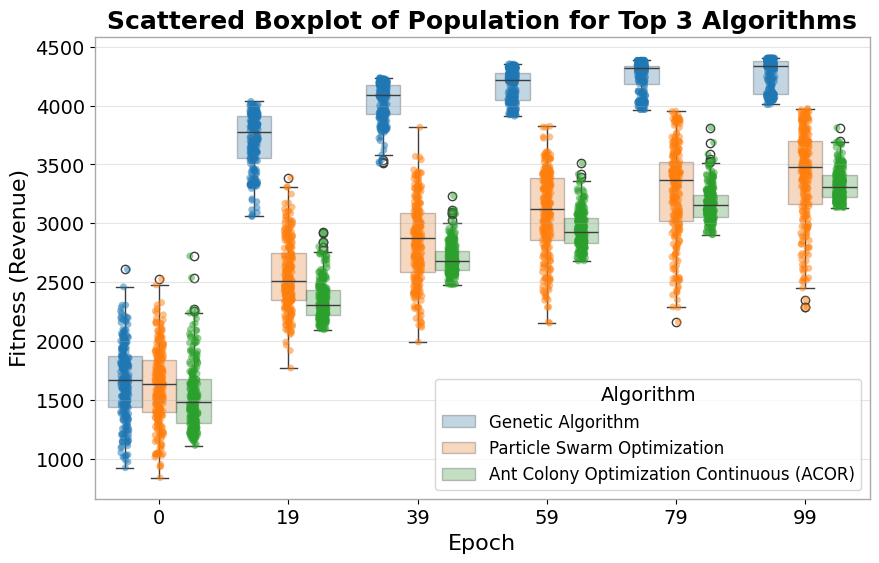

In [45]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Algorithm',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25.pdf'))

In [21]:
# Table with results by run

sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behaviour,
                         line=line,
                         safe_headway=10)

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Algorithm', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('Algo')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"
        row_data =  [algo_group[0], run, revenue, execution_time, 
                     scheduled_trains, np.round(delta_dt, 2), np.round(delta_tt, 2), *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

Algorithm  Run  Revenue  \
24                                Genetic Algorithm    5  6226.82   
22                                Genetic Algorithm    3  6211.51   
20                                Genetic Algorithm    1  6036.68   
23                                Genetic Algorithm    4  6019.80   
21                                Genetic Algorithm    2  5984.39   
48                     Whale Optimization Algorithm    4  5249.33   
38                      Particle Swarm Optimization    4  5227.43   
16                           Differential Evolution    2  5091.43   
15                           Differential Evolution    1  5087.58   
47                     Whale Optimization Algorithm    3  5070.57   
36                      Particle Swarm Optimization    2  5015.60   
19                           Differential Evolution    5  5014.14   
45                     Whale Optimization Algorithm    1  4966.33   
17                           Differential Evolution    3  4840.41   
49                     Whale Optimization Algorithm    5  4767.02   
35                      Particle Swarm Optimization    1  4722.97   
46                     Whale Optimization Algorithm    2  4608.73   
18                           Differential Evolution    4  4524.37   
39                      Particle Swarm Optimization    5  4513.56   
37                      Particle Swarm Optimization    3  4387.78   
8                             Artificial Bee Colony    4  4271.25   
0         Ant Colony Optimization Continuous (ACOR)    1  4082.65   
2         Ant Colony Optimization Continuous (ACOR)    3  4069.72   
7                             Artificial Bee Colony    3  4044.75   
27                              Grey Wolf Optimizer    3  4011.52   
9                             Artificial Bee Colony    5  3950.32   
3         Ant Colony Optimization Continuous (ACOR)    4  3928.69   
1         Ant Colony Optimization Continuous (ACOR)    2  3847.71   
6                             Artificial Bee Colony    2  3840.68   
4         Ant Colony Optimization Continuous (ACOR)    5  3780.78   
11  Covariance Matrix Adaptation Evolution Strategy    2  3775.06   
29                              Grey Wolf Optimizer    5  3765.33   
28                              Grey Wolf Optimizer    4  3743.91   
10  Covariance Matrix Adaptation Evolution Strategy    1  3696.21   
5                             Artificial Bee Colony    1  3688.10   
34  Hybrid Grey Wolf - Whale Optimization Algorithm    5  3668.08   
25                              Grey Wolf Optimizer    1  3661.51   
30  Hybrid Grey Wolf - Whale Optimization Algorithm    1  3612.47   
26                              Grey Wolf Optimizer    2  3604.62   
32  Hybrid Grey Wolf - Whale Optimization Algorithm    3  3590.77   
31  Hybrid Grey Wolf - Whale Optimization Algorithm    2  3506.38   
41                              Simulated Annealing    2  3481.33   
14  Covariance Matrix Adaptation Evolution Strategy    5  3439.56   
33  Hybrid Grey Wolf - Whale Optimization Algorithm    4  3407.98   
13  Covariance Matrix Adaptation Evolution Strategy    4  3326.87   
12  Covariance Matrix Adaptation Evolution Strategy    3  3196.91   
40                              Simulated Annealing    1  2983.99   
43                              Simulated Annealing    4  2389.46   
44                              Simulated Annealing    5  2312.85   
42                              Simulated Annealing    3  2042.53   

    Execution Time (s.)  Scheduled Trains  Delta DT (min.)  Delta TT (min.)  \
24                82.17                26            423.0            108.0   
22                80.62                28            380.0            140.0   
20                80.43                28            543.0            130.0   
23                83.63                26            289.0            143.0   
21                80.73                28            387.0            170.0   
48                78.04                23       

In [22]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrlllll}\n\\toprule\n & Algorithm & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU1 & RU4 & RU5 & RU3 & RU2 \\\\\n\\midrule\n24 & Genetic Algorithm & 5 & 6226.820000 & 82.170000 & 26 & 423.000000 & 108.000000 & 40.0 % & 58.33 % & 58.33 % & 61.54 % & 25.0 % \\\\\n22 & Genetic Algorithm & 3 & 6211.510000 & 80.620000 & 28 & 380.000000 & 140.000000 & 40.0 % & 66.67 % & 66.67 % & 53.85 % & 37.5 % \\\\\n20 & Genetic Algorithm & 1 & 6036.680000 & 80.430000 & 28 & 543.000000 & 130.000000 & 40.0 % & 66.67 % & 58.33 % & 61.54 % & 37.5 % \\\\\n23 & Genetic Algorithm & 4 & 6019.800000 & 83.630000 & 26 & 289.000000 & 143.000000 & 60.0 % & 58.33 % & 58.33 % & 53.85 % & 25.0 % \\\\\n21 & Genetic Algorithm & 2 & 5984.390000 & 80.730000 & 28 & 387.000000 & 170.000000 & 60.0 % & 58.33 % & 58.33 % & 69.23 % & 25.0 % \\\\\n48 & Whale Optimization Algorithm & 4 & 5249.330000 & 78.040000 & 23 & 775.000000 & 76.000000 & 40.0 % & 50.0 % 

In [23]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Ant Colony Optimization Continuous (ACOR) status:
	Total execution time: 2.2644 s.
	Execution Time (by run) - Mean: 0.4529 s. - Std: 0.0083 s.
	Revenue - Mean: 3941.9094 - Std: 133.3718
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Artificial Bee Colony status:
	Total execution time: 8.0624 s.
	Execution Time (by run) - Mean: 1.6125 s. - Std: 0.0238 s.
	Revenue - Mean: 3959.023 - Std: 219.2693
	Scheduled Trains - Mean: 21.0 - Std: 2.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Covariance Matrix Adaptation Evolution Strategy status:
	Total execution time: 12.6699 s.
	Execution Time (by run) - Mean: 2.534 s. - Std: 0.3328 s.
	Revenue - Mean: 3486.9234 - Std: 244.3291
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11321.75 - WARNING!: Scheduling all services could not be feasible

Global Differential Evolution status:
	Total execution time: 3.9

In [24]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('Algo')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'Algorithm': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

Algorithm  \
0                                Genetic Algorithm   
1                     Whale Optimization Algorithm   
2                           Differential Evolution   
3                      Particle Swarm Optimization   
4                            Artificial Bee Colony   
5        Ant Colony Optimization Continuous (ACOR)   
6                              Grey Wolf Optimizer   
7  Hybrid Grey Wolf - Whale Optimization Algorithm   
8  Covariance Matrix Adaptation Evolution Strategy   
9                              Simulated Annealing   

   Mean Execution Time (seconds)  Std Execution Time (seconds)  \
0                          81.52                          1.37   
1                          78.28                          0.41   
2                          79.39                          0.91   
3                          79.96                          0.69   
4                         159.61                          1.15   
5                          44.80                          0.34   
6                          78.27                          0.75   
7                          78.04                          0.67   
8                         260.88                         34.55   
9                          79.53                          1.36   

   Mean Fitness (revenue)  Std Fitness (revenue)  Mean Scheduled Trains  \
0                 6095.84                 114.28                     27   
1                 4932.40                 251.40                     19   
2                 4911.59                 239.18                     24   
3                 4773.47                 347.69                     23   
4                 3959.02                 219.27                     21   
5                 3941.91                 133.37                     23   
6                 3757.38                 156.01                     20   
7                 3557.14                 101.64                     20   
8                 3486.92                 244.33                     21   
9                 2642.03                 581.58                     20   

   Std Scheduled Trains  
0                     1  
1                     2  
2                     1  
3                     1  
4                     2  
5                     1  
6                     1  
7                     1  
8                     1  
9                     2

In [25]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & Algorithm & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Genetic Algorithm & 81.520000 & 1.370000 & 6095.840000 & 114.280000 & 27 & 1 \\\\\n1 & Whale Optimization Algorithm & 78.280000 & 0.410000 & 4932.400000 & 251.400000 & 19 & 2 \\\\\n2 & Differential Evolution & 79.390000 & 0.910000 & 4911.590000 & 239.180000 & 24 & 1 \\\\\n3 & Particle Swarm Optimization & 79.960000 & 0.690000 & 4773.470000 & 347.690000 & 23 & 1 \\\\\n4 & Artificial Bee Colony & 159.610000 & 1.150000 & 3959.020000 & 219.270000 & 21 & 2 \\\\\n5 & Ant Colony Optimization Continuous (ACOR) & 44.800000 & 0.340000 & 3941.910000 & 133.370000 & 23 & 1 \\\\\n6 & Grey Wolf Optimizer & 78.270000 & 0.750000 & 3757.380000 & 156.010000 & 20 & 1 \\\\\n7 & Hybrid Grey Wolf - Whale Optimization Algorithm & 78.040000 & 0.670000 & 3557.140000 & 101.640000 & 2

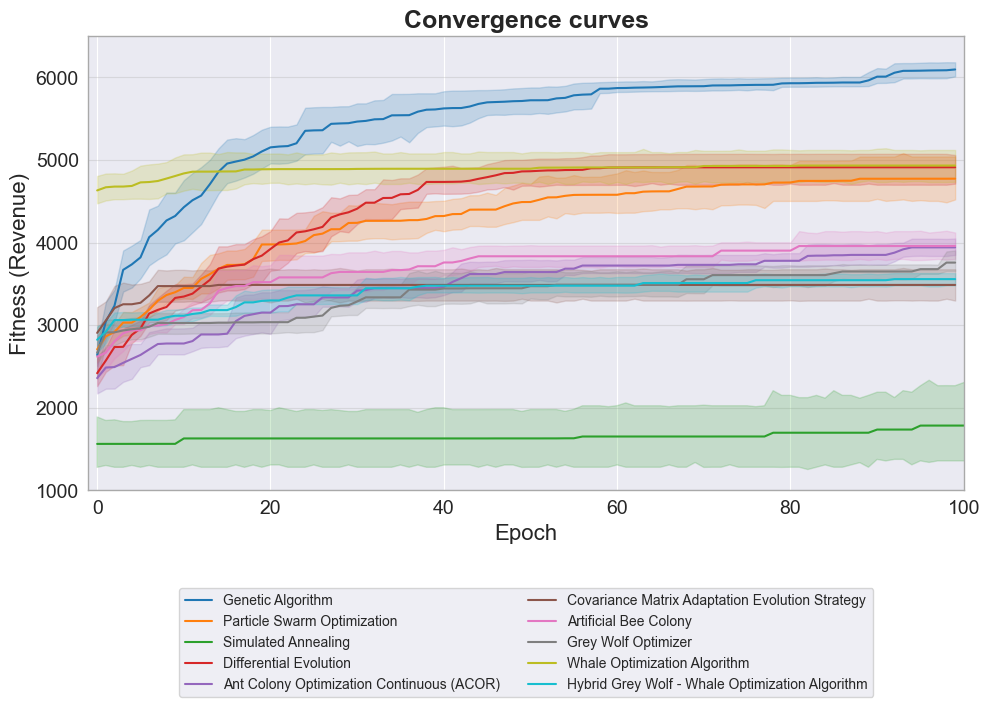

In [27]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(1000,6500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed.pdf'),
              fig_size=(10, 9))

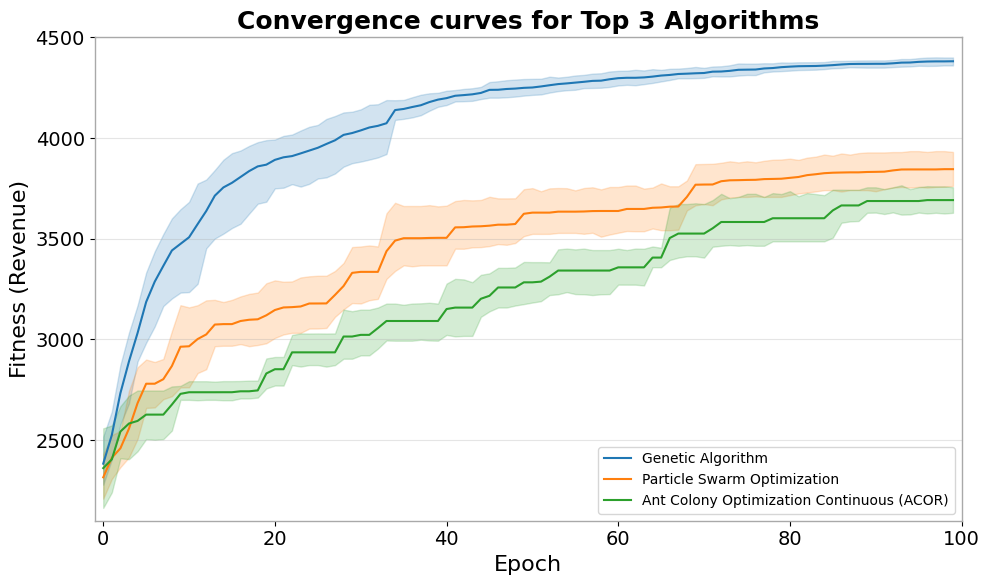

In [52]:
top_3_algos = ("Genetic Algorithm",
               "Particle Swarm Optimization",
               "Ant Colony Optimization Continuous (ACOR)")

# Create dataframe with fitness values for each individual of the population
df_history_top_3 = df_history[df_history['Algo'].isin(top_3_algos)]

sns_line_plot(df=df_history_top_3,
              x_data="Iteration",
              y_data="Fitness",
              hue="Algo",
              title="Convergence curves for Top 3 Algorithms",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(2100,4500),
              save_path=Path('../reports/mealpy/mealpy_convergence_5_seed_top_3.pdf'),
              fig_size=(10, 7))

In [84]:
df_history.head()

Run               Algo  Iteration      Fitness  ExecutionTime  \
0    1  Genetic Algorithm          0  2459.878405       0.246457   
1    1  Genetic Algorithm          1  2460.308339       0.243454   
2    1  Genetic Algorithm          2  2574.487027       0.243266   
3    1  Genetic Algorithm          3  2926.528932       0.239713   
4    1  Genetic Algorithm          4  3015.854710       0.239389   

                                            Discrete  \
0  [False, True, False, True, True, True, True, F...   
1  [False, True, False, True, True, True, True, F...   
2  [False, True, False, True, True, True, True, F...   
3  [False, True, False, True, True, True, True, F...   
4  [False, True, False, True, True, False, True, ...   

                                                Real  Diversity  Exploitation  \
0  [1070, 1114, 1143, 867, 970, 1046, 902, 827, 9...   3.209825      0.000000   
1  [1061, 1109, 1142, 864, 970, 1045, 898, 822, 9...   2.827368     11.915173   
2  [1061, 1109, 1142, 872, 970, 1045, 902, 822, 9...   2.692281     16.123743   
3  [1061, 1109, 1143, 872, 970, 1045, 902, 822, 9...   2.463509     23.250984   
4  [1061, 1109, 1144, 866, 971, 1046, 904, 827, 9...   2.223509     30.728028   

   Exploration  
0   100.000000  
1    88.084827  
2    83.876257  
3    76.749016  
4    69.271972

In [102]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

[1741.0809259234882,
 1748.684776735114,
 1776.928458652797,
 1787.0886195088412,
 1789.277000079085,
 1810.0148541336189,
 1819.9926110593465,
 1821.784191284223,
 1959.0674056539915,
 1965.464324500664,
 1974.408813245351,
 1974.408813245351,
 1993.9478517839375,
 1995.1817405334048,
 1995.1817405334048,
 2199.511541491974,
 2203.9916559426238,
 2203.991655942644,
 2210.439801087261,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2218.9944671113813,
 2221.9108097656595,
 2225.2391621379447,
 2229.040605359691,
 2241.1760454529403,
 2248.2693960385377,
 2526.072256796473,
 2526.2577480508426,
 2526.257748050876,
 2533.5882980193096,
 2533.5882980193096,
 2534.321215424944,
 2536.263289652836,
 2536.9962070584693,
 2536.9962070584693,
 2538.275235491649,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2558.405138870365,
 2560.428120624755,
 2560.428120624755,
 2564.110568615207,
 2569.815642866672,
 2573.933454008949,
 2575.597474624795,
 2575.597474624795

In [20]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

[2607.780704168451,
 2703.21640230218,
 2911.444314465418,
 3103.973183542429,
 3220.667590931876,
 3365.2866137766955,
 3484.48609472132,
 3572.9260730745227,
 3640.073782168727,
 3669.5832622522,
 3705.136185446733,
 3794.5588181089274,
 3839.792800278671,
 3863.719004722367,
 3906.153305799562,
 3960.321202641717,
 3960.321202641717,
 4005.737551227856,
 4021.701509559909,
 4036.1238629427503,
 4036.374965155991,
 4037.255279037032,
 4047.601165890613,
 4072.3073805030704,
 4100.486496755227,
 4102.769254199621,
 4125.723121565449,
 4149.827532752619,
 4172.08849602329,
 4172.08849602329,
 4183.598501918915,
 4194.791579881078,
 4197.818016088964,
 4226.226027636936,
 4226.226027636936,
 4226.226027636936,
 4228.039611525929,
 4228.705076393186,
 4240.677771701874,
 4240.677771701874,
 4253.38097286305,
 4253.38097286305,
 4253.38097286305,
 4256.742944859372,
 4261.969159858364,
 4309.924958575424,
 4310.657875981058,
 4323.559176282795,
 4323.559176282795,
 4323.559176282795,
 432

In [21]:
print(len(algo_vals))

100


In [26]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

[2121.942526311217,
 2126.1450191909216,
 2153.200797898652,
 2172.1936191864675,
 2174.216600940857,
 2195.3208372725726,
 2204.6153864302687,
 2223.3679354022047,
 2225.390917156595,
 2244.3606160414943,
 2244.3606160414943,
 2247.4535123926985,
 2270.379052946466,
 2270.492084344696,
 2274.816620508482,
 2298.572311796074,
 2316.002237825652,
 2316.002237825652,
 2316.002237825652,
 2320.215221955512,
 2325.565748811522,
 2332.3340863078133,
 2339.717662177076,
 2345.9459463700828,
 2349.005632648977,
 2583.144820693363,
 2590.85225513937,
 2592.3896854296745,
 2596.703525330692,
 2596.703525330692,
 2599.58923714303,
 2623.8452559548505,
 2623.8452559548505,
 2628.9170645467857,
 2630.988554963445,
 2635.5254248523797,
 2649.8720529088614,
 2655.7557863545885,
 2659.9093170072138,
 2660.827594946524,
 2668.118106647075,
 2668.118106647075,
 2671.661031899009,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743,
 2673.3758957005743

In [27]:
print(len(algo_vals))

100


In [28]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [29]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

Wilcoxon Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      3.0   
Covariance Matrix Adaptation Evolution Strategy               39.0   
Artificial Bee Colony                                          1.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                 239.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                        0.0   
Particle Swarm Optimization                          

In [30]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

P-Values Matrix
                                                 Genetic Algorithm  \
Genetic Algorithm                                              NaN   
Particle Swarm Optimization                                    0.0   
Simulated Annealing                                            0.0   
Differential Evolution                                         0.0   
Ant Colony Optimization Continuous (ACOR)                      0.0   
Covariance Matrix Adaptation Evolution Strategy                0.0   
Artificial Bee Colony                                          0.0   
Grey Wolf Optimizer                                            0.0   
Whale Optimization Algorithm                                   0.0   
Hybrid Grey Wolf - Whale Optimization Algorithm                0.0   

                                                 Particle Swarm Optimization  \
Genetic Algorithm                                                      0.000   
Particle Swarm Optimization                          

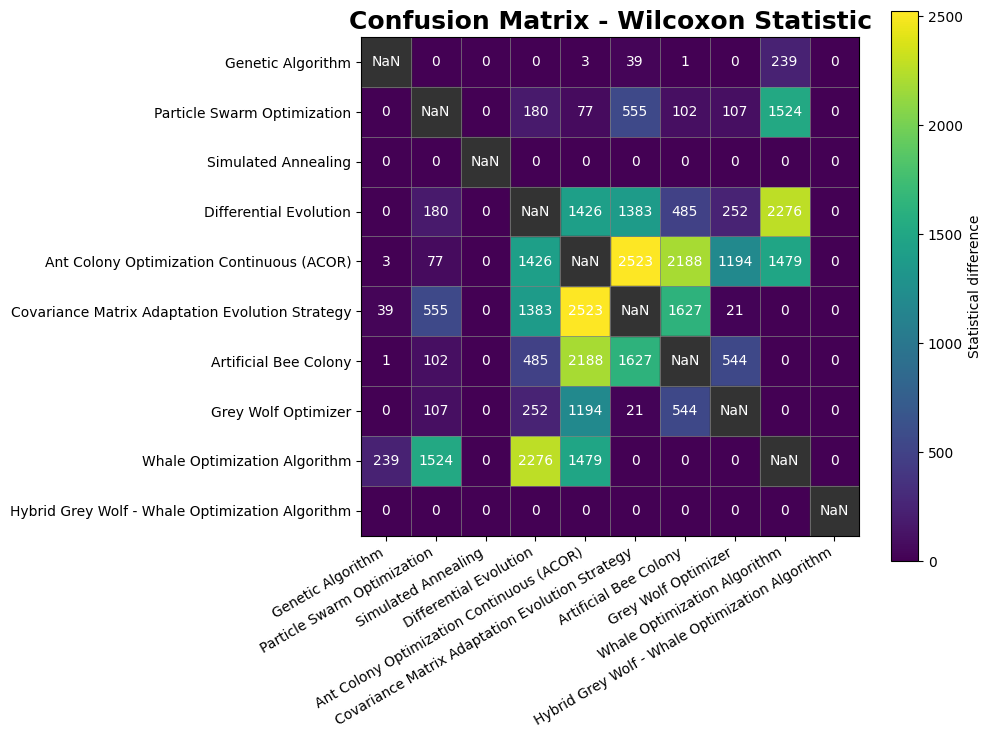

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

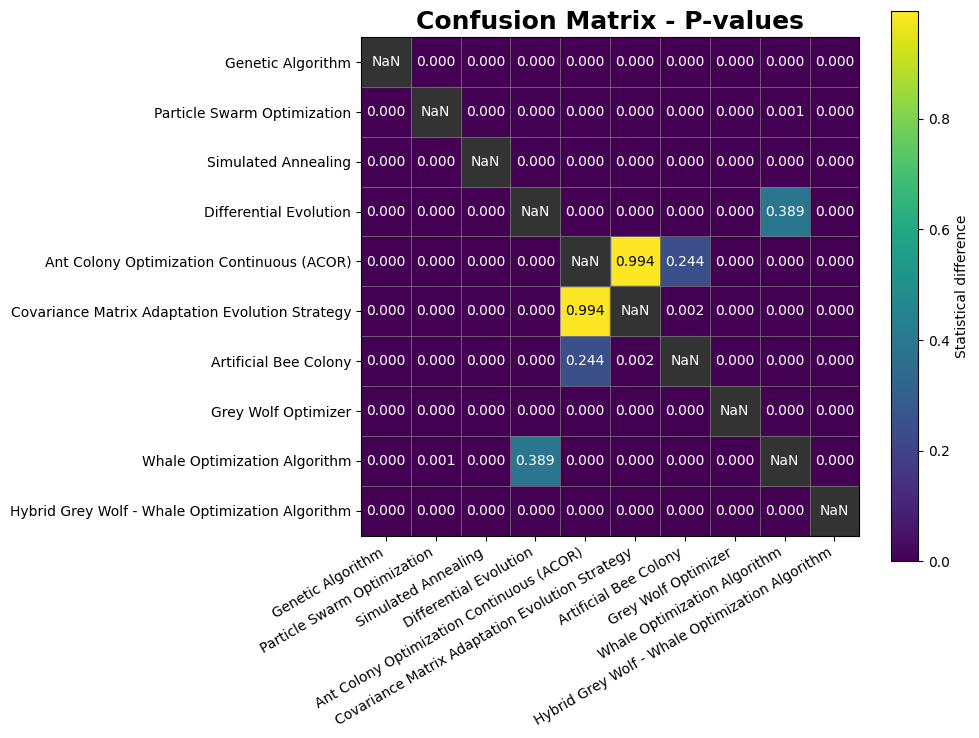

In [33]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

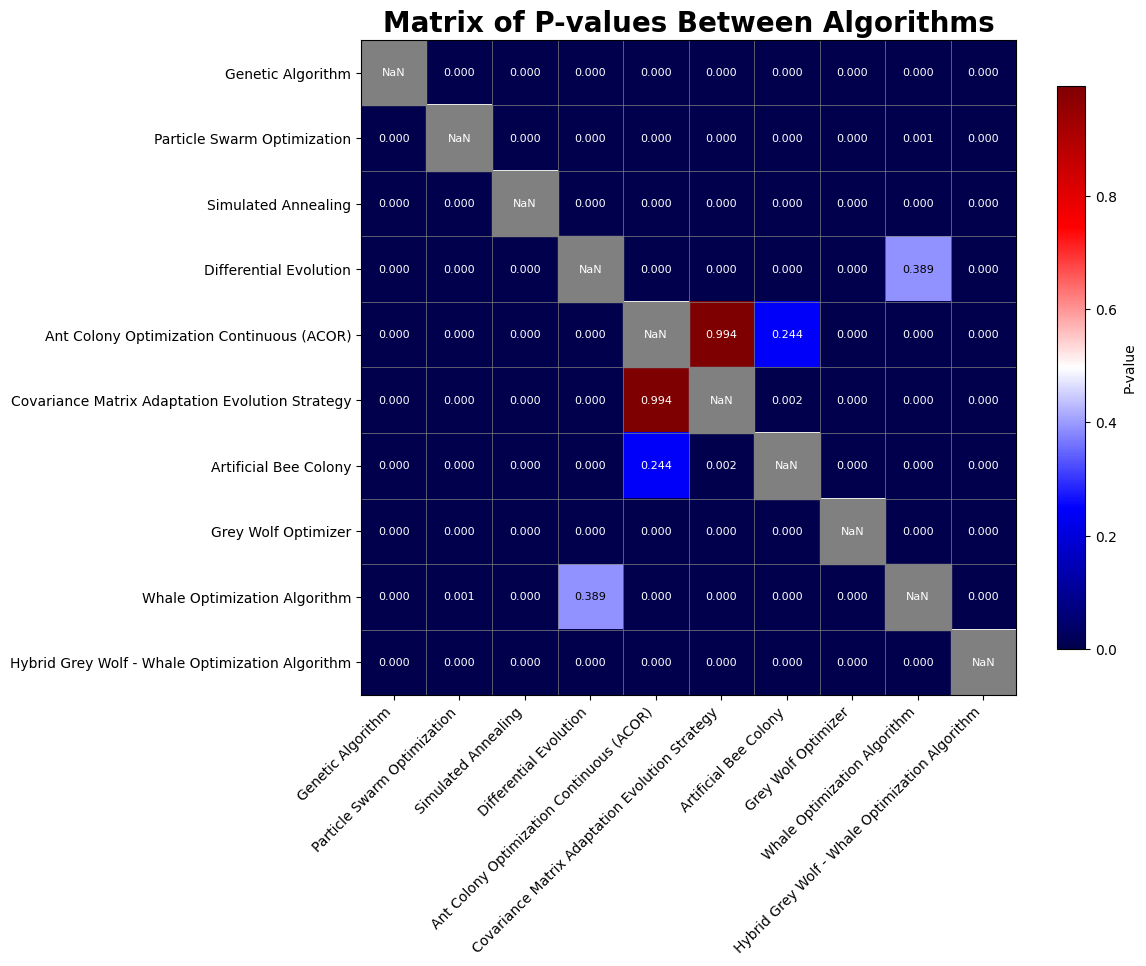

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [36]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0625


In [37]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 5
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

Real: [1065. 1112. 1142.  873.  972. 1046.  907.  828.  913. 1355.  731.  130.
  210.  271.  479.  531.  630.  693.  930.  748.  177.  399.  463.  506.
  939.  968. 1038. 1094. 1132. 1161. 1188. 1253. 1309. 1345.  422.  466.
  503.  278.  336.  374.  528.  570. 1070. 1190. 1249. 1288.  559.  613.
  649. 1241.  462.  525.  567. 1276.  898.  998. 1060.], Discrete: [False  True False  True  True  True  True False  True False  True  True
  True  True  True False  True False  True  True  True  True  True  True
  True]


In [25]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/mealpy/ supply_config_gsa


In [26]:
final_supply = Supply.from_yaml(supply_config_file)

/Users/uclm/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


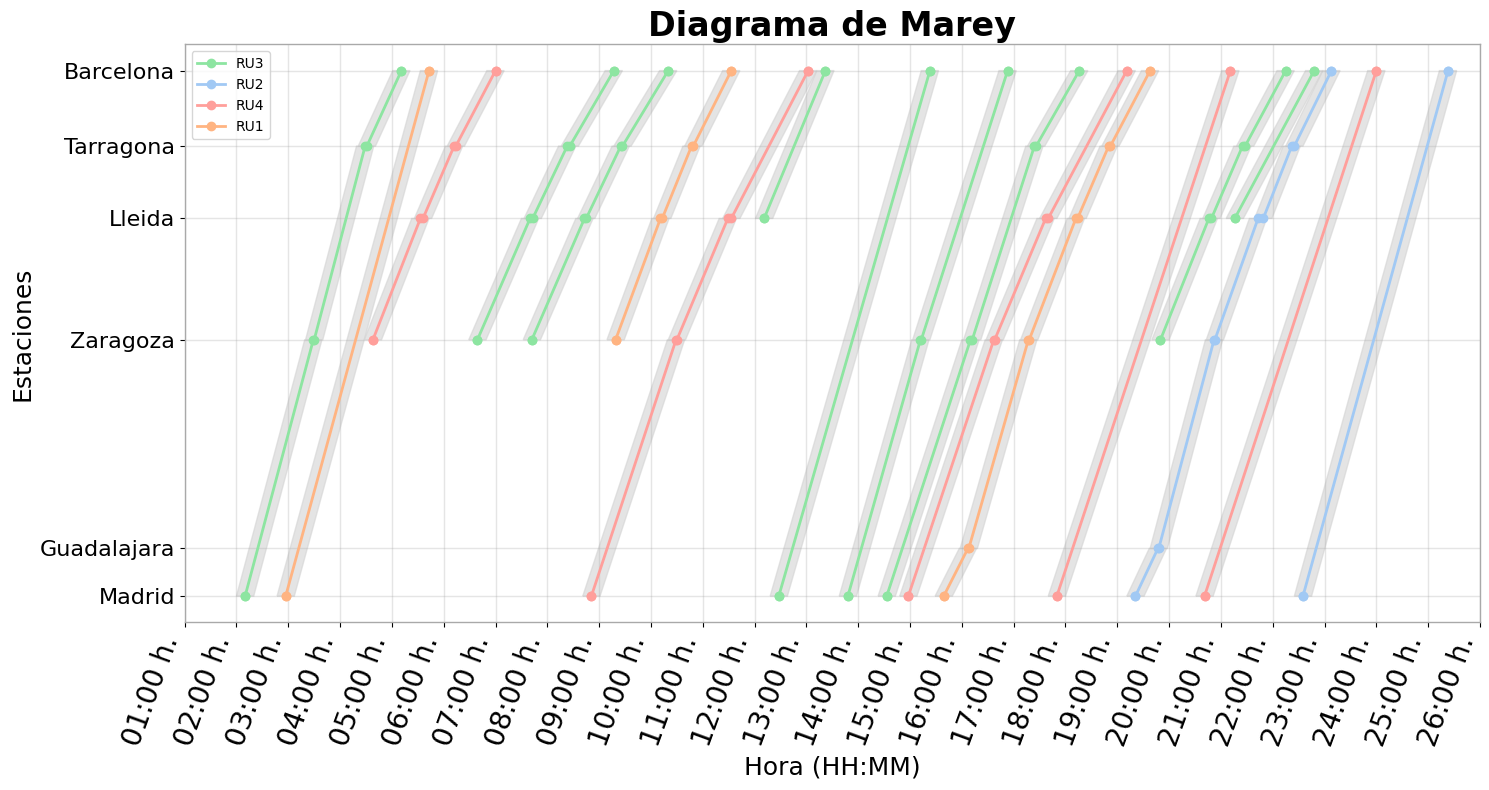

In [27]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [38]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'mealpy/{tt_file_name}_25.yml')

PosixPath('../reports/mealpy/supply_config_gsa_25.yml')

In [30]:
#!snakeviz profile.pstat